In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import product
import pandas as pd
import seaborn as sns

pq0, alfa = 0.01 , 0.4

In [2]:
def constroe_estados(profundidade):
    estados = {}
    estados_list = []
    for v in range(profundidade+1):
        aux = list(product([v],list(range(0,v+1))))
        estados[str(v)] =  aux
        estados_list = estados_list + aux

    estados[str(profundidade)] = [(-1,-1)]  
    estados_list = estados_list+[(-1,-1)]
    return estados,estados_list

def proximos(estado,profundidade):
    atingiveis = {}
    if estado[0]<profundidade and estado[0]>=0:
        atingiveis["estados"] = [(estado[0]+1,estado[1]+1),(estado[0]+1,0),(estado[0]+1,0),(0,0)]
        atingiveis["acoes"] = [0,0,1,2]

        aux_q = pq0/(pq0+(1-pq0)*np.exp(-alfa*estado[1]))
        
        atingiveis["probs"] = [1-aux_q,aux_q,1,1]
        atingiveis["recs"] = recompensa(estado)
    elif estado[0]==-1 or estado[0]==profundidade:
        atingiveis["estados"] = [(-1,-1),(-1,-1),(-1,-1),(-1,-1)]
        atingiveis["acoes"] = [0,0,1,2]
        atingiveis["probs"] = [1,0,1,1] 
        atingiveis["recs"] = [0,0,0,0]   

    return atingiveis

def anteriores(estado):
    if estado[1]>0:
        ants = [(estado[0]-1,estado[1]-1)]
    elif estado[1]==0 and estado[0]>0:
        ants = list(product([estado[0]-1],list(range(0,estado[0]-1))))
        
    return ants

def transicao(estado1,estado2,acao,profundidade):
    if acao == 0:
        aux_q = pq0/(pq0+(1-pq0)*np.exp(-alfa*estado1[1]))
        
        pq = aux_q   
        probs = 1-pq
        dx0 = estado2[0]-estado1[0]
        if dx0 == 1:
            dy0 = estado2[1]-estado1[1]
            if dy0 == 1:
                pr = probs
            elif estado2[1]==0:
                pr = pq 
            else:
                pr = 0  
        else:
            pr = 0
            
    elif acao == 1:
        dx0 = estado2[0]-estado1[0]
        if dx0==1 and estado1[0]==0:
            pr = 1
        else:
            pr = 0
        
    elif acao == 2:
        if estado2[1] == 0 and estado2[0] == 0:
            pr = 1
        else:
            pr = 0
    else:
        pr = 0
    
    if estado2[0]==-1:
        if estado1[0] == profundidade:
            pr = 1
        else:
            pr = 0
    if estado1[0]==-1:
        if estado2[0] == -1:
            pr = 1
        else:
            pr = 0
    return pr

def recompensa(estado):
    tvida,trev = estado[0],estado[1]

    valor_equipamento = np.exp(-0.005*tvida)
    valor_manutencao = 0.02 - 0.01*np.exp(-0.1*tvida)

    # pq = pq0/(pq0+(1-pq0)*np.exp(-alfa*trev))
    valor_defeito = -2*valor_manutencao/valor_equipamento
        
    res_a01,res_a02 = 0.01/valor_equipamento,valor_defeito

    res_a1 = -valor_manutencao/valor_equipamento
    
    res_a2 = -(1 - 0.8*valor_equipamento)
    
    res = [res_a01,res_a02,res_a1,res_a2]
    if estado[0]==-1:
        res = [0,0,0,0]
    return res


def cria_politica(lista_estados):
    politica = {}
    for est in lista_estados:
        politica[est] = [1,0,0]
    return politica

def avalia_politica(sims, lista_estados,politica):
    tol = 1e-5
    prof = lista_estados[-2][0]
    
    VN = {v:1-2*random.random() for v in lista_estados}
    VN[(-1,-1)]=0
    
    cnt, nor = 0, 10
    
    M = {}
    M[0] = np.array(list(V.values()))
    while nor>tol and cnt <= sims:
        
        V = {k:v for k,v in VN.items()}
        VN = {}

        for est in lista_estados:
            next = proximos(est,prof) 
            nest = next["estados"]
            probs = next["probs"]
            recs = next["recs"]
            pols = politica[est]

            v_a0 = probs[0]*(recs[0]+V[nest[0]])+probs[1]*(recs[1]+V[nest[1]])
            v_a1 = probs[2]*(recs[2]+V[nest[2]])
            v_a2 = probs[3]*(recs[3]+V[nest[3]])

            VN[est] = pols[0]*v_a0+pols[1]*v_a1+pols[2]*v_a2
        
        cnt = cnt+1
        M[cnt] = np.array(list(VN.values()))

        nor = np.linalg.norm(M[cnt]-M[cnt-1])
        # aux.append(nor)
    return M

def aprimora_politica(lista_estados,politica,sims = 50):
    # escolhe a melhor política deterministica
    tol = 1e-5
    prof = lista_estados[-2][0]
    
    VN = {v:1-2*random.random() for v in lista_estados}
    VN[(-1,-1)]=0
    
    # politica = {est:0 for v in lista_estados}

    P,M = {},{}
    PLN = {k:v for k,v in politica.items()}

    P[0] = politica
    
    cnt_pol = 0

    estavel = False

    while not estavel and cnt_pol<500:
        cnt_pol = cnt_pol+1
        
        PL = {k:v for k,v in PLN.items()}
        PLN = {}
        
        cnt, nor = 0, 10
        while nor>tol and cnt <= sims:
            
            V = {k:v for k,v in VN.items()}
            VN = {}

            for est in lista_estados:
                next = proximos(est,prof) 
                nest = next["estados"]
                probs = next["probs"]
                recs = next["recs"]
                pols = politica[est]

                v_a0 = probs[0]*(recs[0]+V[nest[0]])+probs[1]*(recs[1]+V[nest[1]])
                v_a1 = probs[2]*(recs[2]+V[nest[2]])
                v_a2 = probs[3]*(recs[3]+V[nest[3]])

                VN[est] = pols[0]*v_a0+pols[1]*v_a1+pols[2]*v_a2
            
            cnt = cnt+1
            nor = np.linalg.norm(np.array(list(V.values()))-np.array(list(VN.values())))
        
        V = {k:v for k,v in VN.items()}
        M[cnt_pol-1] = {k:v for k,v in VN.items()}
        mud = 0
        for est in lista_estados:
            next = proximos(est,prof) 
            nest = next["estados"]
            probs = next["probs"]
            recs = next["recs"]
            pols = politica[est]
            v_a0 = probs[0]*(recs[0]+V[nest[0]])+probs[1]*(recs[1]+V[nest[1]])
            v_a1 = probs[2]*(recs[2]+V[nest[2]])
            v_a2 = probs[3]*(recs[3]+V[nest[3]])
            idx_pol_max = np.argmax([v_a0,v_a1,v_a2])
            aux_pol = [0,0,0]
            aux_pol[idx_pol_max]=1
            PLN[est] = aux_pol
            
            if not pols[idx_pol_max] == 1:
                mud = mud+1

        if mud > 0:
            estavel = False
        else:
            estavel = True
            
        politica = {k:v for k,v in PLN.items()}
        P[cnt_pol] = {k:v for k,v in PLN.items()}

    cnt, nor = 0, 10
    while nor>tol and cnt <= sims:
        
        V = {k:v for k,v in VN.items()}
        VN = {}

        for est in lista_estados:
            next = proximos(est,prof) 
            nest = next["estados"]
            probs = next["probs"]
            recs = next["recs"]
            pols = politica[est]
            
            v_a0 = probs[0]*(recs[0]+V[nest[0]])+probs[1]*(recs[1]+V[nest[1]])
            v_a1 = probs[2]*(recs[2]+V[nest[2]])
            v_a2 = probs[3]*(recs[3]+V[nest[3]])

            VN[est] = pols[0]*v_a0+pols[1]*v_a1+pols[2]*v_a2

        cnt = cnt+1
        nor = np.linalg.norm(np.array(list(V.values()))-np.array(list(VN.values())))
    
    M[cnt_pol] = {k:v for k,v in VN.items()}
    
    return P,M


def value_iteration(lista_estados,politica,sims = 500):
    # escolhe a melhor política deterministica
    tol = 1e-5
    prof = lista_estados[-2][0]
    
    VN = {v:0.05 for v in lista_estados}
    VN[(-1,-1)] = 0

    PLN = {k:np.argmax(v) for k,v in politica.items()}
    
    M,P = {},{}
    M[0] = np.array(list(VN.values()))
    P[0] = {k:v for k,v in PLN.items()}
    
    cnt, nor = 0, 10
    while nor>tol and cnt <= sims:
        
        PL = {k:v for k,v in PLN.items()}
        PLN = {}
        
        V = {k:v for k,v in VN.items()}
        VN = {}

        for est in lista_estados:
            next = proximos(est,prof) 
            nest = next["estados"]
            probs = next["probs"]
            recs = next["recs"]
        
            v_a0 = probs[0]*(recs[0]+V[nest[0]])+probs[1]*(recs[1]+V[nest[1]])
            v_a1 = probs[2]*(recs[2]+V[nest[2]])
            v_a2 = probs[3]*(recs[3]+V[nest[3]])

            VN[est] = np.max([v_a0,v_a1,v_a2])
            PLN[est] = np.argmax([v_a0,v_a1,v_a2])
            
        cnt = cnt+1
        nor = np.linalg.norm(np.array(list(V.values()))-np.array(list(VN.values())))
        M[cnt] = np.array(list(VN.values()))
        P[cnt] = {k:v for k,v in PLN.items()}
    
    return P, M

def gera_episodio(prof,T,politica,est0):

    est = (est0[0],est0[1])
    epi,t = [],0
    while t<T:
        t = t+1
        polis = np.cumsum(politica[est])
        aux_ac = random.random()
        ac = np.sum([int(x<aux_ac) for x in polis])
        nxt = proximos(est,prof)
        if ac == 0:
            aux_n = random.random()
            if aux_n <= nxt["probs"][0]:
                rec = nxt["recs"][0]
                nest = nxt["estados"][0]
            else:
                rec = nxt["recs"][1]
                nest = nxt["estados"][1]
        elif ac == 1:
            rec = nxt["recs"][2]
            nest = nxt["estados"][2]
        elif ac == 2:
            rec = nxt["recs"][3]
            nest = nxt["estados"][3]

        epi.append([est,ac,rec])
        est = (nest[0],nest[1])

    
    return epi

def FirstVisitMC(T,profundidade,est0=(0,0),n_eps = 1000):
    _, lista_estados = constroe_estados(profundidade)
    
    # pols = cria_politica(lista_estados)
    pols = {}
    for est in lista_estados:
        pols[est] = [0.9,0.1,0.0]
    
    N = {v:0 for v in lista_estados}
    R = {v:0 for v in lista_estados}
    V = {v:0 for v in lista_estados}
    
    prof = profundidade
    for n in range(n_eps):
        epi = gera_episodio(prof,T,pols,est0)

        estados = [epi[t][0] for t in range(len(epi)-1,-1,-1)]
        
        G = 0
        for t in range(len(epi)-2,-1,-1):
            G = G + epi[t][2]
            est = epi[t][0]
            if est not in estados[:t]:
                R[est] = R[est] + G
                N[est] = N[est] + 1

    for est in lista_estados:
        V[est] = R[est]/(N[est]+1e-15)               

    return N,R,V

def OnPolicyFirstVisitMC(T,profundidade,est0=(0,0),n_eps = 1000,tol=0.15):
    # escolhe a melhor política deterministica
    _, lista_estados = constroe_estados(profundidade)
    
    pols = {}
    lista_estados_acoes = []
    for est in lista_estados:
        aux = [0.8,.2,.0]
        pols[est] = [x/sum(aux) for x in aux]
        for i in range(3):
            lista_estados_acoes.append(((est[0],est[1]),i))


    
    prof = profundidade
    N = {v:1e-15 for v in lista_estados_acoes}
    R = {v:0 for v in lista_estados_acoes}
    V = {v:0 for v in lista_estados_acoes}
    for n in range(n_eps):
        epi = gera_episodio(prof,T,pols,random.choice(lista_estados))

        estados_acoes = [(epi[x][0],epi[x][1]) for x in range(len(epi)-1,-1,-1)]
        estados_acoes = [(epi[x][0],epi[x][1]) for x in range(len(epi))]
        
        G = 0
        for t in range(len(epi)-2,-1,-1):
            G = G + epi[t][2]
            est = (epi[t][0],epi[t][1])
            if est not in estados_acoes[:t]:
                N[est] = N[est] + 1
                V[est] = V[est]+(G-V[est])/N[est]
                vals = [-100,-100,-100]
                for i in range(3):
                    if N[(est[0],i)]>=1:
                        vals[i] = V[(est[0],i)]
                acm = np.argmax(vals)
                aux_pol = [tol/3,tol/3,tol/3]
                aux_pol[acm] = 1-tol+tol/3
                pols[est[0]] = aux_pol

    return N,R,V,pols

In [ ]:
N,R,V,P= OnPolicyFirstVisitMC(20,profundidade = 20,n_eps=100000)


In [ ]:
P

In [ ]:
xx = {k:np.argmax(v) for k,v in P.items()}
[k for k,v in xx.items() if v>0]

In [3]:
prof = 54
_, est_list = constroe_estados(prof)
polis = cria_politica(est_list)
# M = avalia_politica(50,est_list,politica)
P, M = value_iteration(est_list,polis)
# x = [a[0] for a,b in zip(P[0].items(),P[].items()) if not a[1]==b[1]]

<AxesSubplot: >

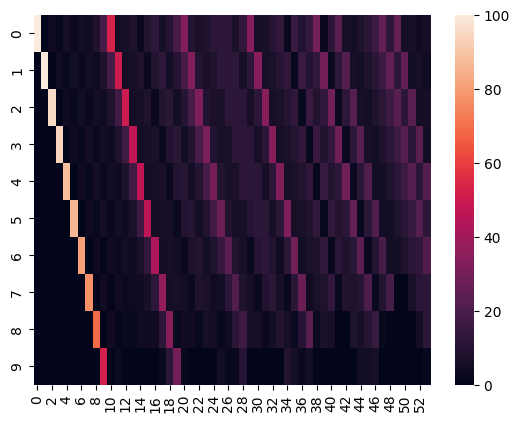

In [66]:
sns.heatmap(M)

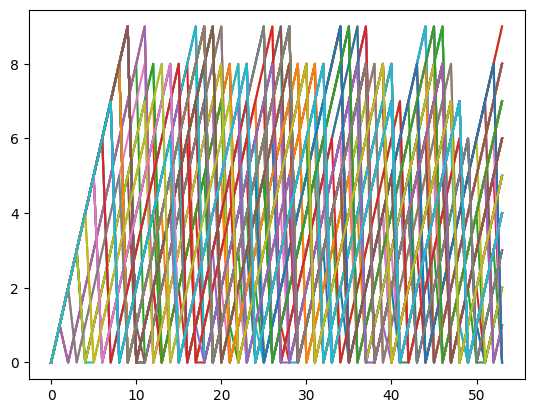

In [63]:
pol = {}
for k,v in P[112].items():
    aux = [0,0,0]
    aux[v] = 1
    pol[k] = aux

epis = []
fig,ax = plt.subplots()
M = np.zeros(shape=(10,prof))
for i in range(100):
    epi = gera_episodio(prof,prof,pol,(0,0))
    x, y = [],[]
    for j in range(prof):
        est = epi[j][0]
        x.append(est[0])
        y.append(est[1])
        M[est[1],j]= M[est[1],j] + 1 
    sns.lineplot(x=x,y=y,ax = ax,hue=None)
plt.show()

In [7]:
x = [a[0] for a,b in zip(P[0].items(),P[112].items()) if not a[1]==b[1]]
y = [k for k,v in P[112].items() if v==1]
y


[(9, 9),
 (10, 9),
 (10, 10),
 (11, 8),
 (11, 9),
 (11, 10),
 (11, 11),
 (12, 8),
 (12, 9),
 (12, 10),
 (12, 11),
 (12, 12),
 (13, 8),
 (13, 9),
 (13, 10),
 (13, 11),
 (13, 12),
 (13, 13),
 (14, 8),
 (14, 9),
 (14, 10),
 (14, 11),
 (14, 12),
 (14, 13),
 (14, 14),
 (15, 8),
 (15, 9),
 (15, 10),
 (15, 11),
 (15, 12),
 (15, 13),
 (15, 14),
 (15, 15),
 (16, 9),
 (16, 10),
 (16, 11),
 (16, 12),
 (16, 13),
 (16, 14),
 (16, 15),
 (16, 16),
 (17, 9),
 (17, 10),
 (17, 11),
 (17, 12),
 (17, 13),
 (17, 14),
 (17, 15),
 (17, 16),
 (17, 17),
 (18, 9),
 (18, 10),
 (18, 11),
 (18, 12),
 (18, 13),
 (18, 14),
 (18, 15),
 (18, 16),
 (18, 17),
 (18, 18),
 (19, 9),
 (19, 10),
 (19, 11),
 (19, 12),
 (19, 13),
 (19, 14),
 (19, 15),
 (19, 16),
 (19, 17),
 (19, 18),
 (19, 19),
 (20, 8),
 (20, 9),
 (20, 10),
 (20, 11),
 (20, 12),
 (20, 13),
 (20, 14),
 (20, 15),
 (20, 16),
 (20, 17),
 (20, 18),
 (20, 19),
 (20, 20),
 (21, 8),
 (21, 9),
 (21, 10),
 (21, 11),
 (21, 12),
 (21, 13),
 (21, 14),
 (21, 15),
 (21, 16)

In [8]:
est_list

[(0, 0),
 (1, 0),
 (1, 1),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9),
 (10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (10, 8),
 (10, 9),
 (10, 10),
 (11, 0),
 (11, 1),
 (11, 2),
 (11, 3),
 (11, 4),
 (11, 5),
 (11, 6),
 (11, 7),
 (11, 8),
 (11, 9),
 (11, 10),
 (11, 11),
 (12, 0),
 (12, 1),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 8),
 (12, 9),
 (12, 10),
 (12, 11),
 (12, 12),
 (13, 0),
 (13, 1),
 (13, 2),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 6),
 (13, 7),
 (13, 8),
 (13, 9),
 (13, 10),
 (13, 11),
 (13, 12),
 (13, 

In [ ]:
x = [a[0] for a,b in zip(P[0].items(),P[].items()) if not a[1]==b[1]]

In [ ]:
vals = [v[0] for k,v in M.items()]
sns.lineplot(vals)

In [ ]:
estado = (5,5)
sims = 100
politicas = list(product([0,1,2],[0,1,2],[0,1,2],[0,1,2],[0,1,2],[0,1,2],[0,1,2],[0,1,2]))
tpol = len(politicas)
M = {}
Mr = {}
Ms = {}
media = [0]*tpol

for i in range(sims):
    print(i,end="\r")
    # rec_p = []
    rec_ac_p = []
    # rec_s = []
    for p in politicas:
        rec = []
        # rec_es = [estado]
        cnt = 0
        est = (estado[0],estado[1])
        for x in p:
            auxr = recompensa(est,x)
            # rec.append(auxr)
            cnt = cnt + auxr
            if x==0:
                aux_q = pq0/(pq0+(1-pq0)*np.exp(-alfa*est[1]))
                if random.random()>aux_q:
                    est = (est[0]+1,est[1]+1)
                else:
                    est = (est[0]+1,0)
            elif x==1:
                est = (est[0]+1,0)
            elif x==2:
                est = (0,0)
            # rec_es.append(est)
        rec_ac_p.append(cnt)
        # rec_p.append(rec)
        # rec_s.append(rec_es)
    M[i] = rec_ac_p
    # Mr[i] = rec_p
    # Ms[i] =  rec_s
    media = [media[j]+rec_ac_p[j]/sims for j in range(tpol)]

[politicas[np.argmax(media)],np.max(media)]


            

    

In [ ]:
# med = [0]*len(politicas)
zz = []
for i in range(sims):
    # med = [med[j]+0.1*M[i][j] for j in range(len(politicas))]
    aux = np.argmax(politicas[np.argmax(M[i])])
    zz.append(aux)
    # print(politicas[np.argmax(M[i])],np.max(M[i]))

[z for z in zz if z>0]

In [ ]:
[z for z in zz if z>0]

In [ ]:
prof = 30
est_dicio, est_list = constroe_estados(prof)
recs = []

aux1 = []
aux2 = []
aux3 = []

for x in est_dicio["28"]:
    aux1.append(recompensa(x,0))
    aux2.append(recompensa(x,1))
    aux3.append(recompensa(x,2))


In [ ]:
anteriores((29,0))

In [ ]:
recompensa((10,10),0)
estado1 = []
estado2 = []
acao = []
probs = []
for x in est_list:
    
    

In [ ]:
prof = 30
est_dicio, est_list = constroe_estados(prof)

In [ ]:
est_dicio["29"]

In [ ]:
prof = 30
_ , est_list = constroe_estados(prof)
estado1 = []
estado2 = []
acao = []
probs = []
for x in est_list:
    for y in est_list:
        estado1.append(x)
        estado2.append(y)
        acao.append(0)
        probs.append(transicao(x,y,0))

df = pd.DataFrame({'estado origem':estado1,'estado_chegada':estado2,'acao':acao,"probs":probs})
df

In [ ]:
df[df.probs>0]

In [ ]:
transicao((3,0),(4,2),0)

In [ ]:
proximos((4,0))

In [ ]:
pd.DataFrame(proximos((4,0)))